In [1]:
import h5py
import numpy as np
import os
import pandas as pd
from pathlib import Path
import readgadget
import scipy
import subprocess
import time

from os import listdir
from os.path import isfile, join

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import SymLogNorm

%load_ext autoreload
%autoreload 2
import bacco
import bacco.probabilistic_bias as pb

import sys
sys.path.append('../code')
import plotter

Importing pyfftw first


## CAMELS-SAM ICS from Roman's 2LPT

In [2]:
idx_sam = 16

In [3]:
seed = idx_sam + 5000 # from camels data gen

In [4]:
snapshot = f'/cosmos_storage/kstoreyf/CAMELS-SAM_ICS/LH/LH_{idx_sam}/ics'
#snapshot = '/dipc/kstoreyf/external/run_2lpt_example/ics_Carmen_2001'
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

In [5]:
pos = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
vel = readgadget.read_block(snapshot, "VEL ", ptype)     #peculiar velocities in km/s
ids = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0

get ICs on grid:

In [6]:
box_size = 100. #Mpc/h, camels
ngrid = 640

In [7]:
pos_mesh = bacco.statistics.compute_mesh(ngrid=ngrid, box=box_size, pos=pos, vel=vel, mass=None,
                 interlacing=False, deposit_method='cic', folds=1,
                 zspace=False, cosmology=None, nthreads=None, twod=False)
print(pos_mesh.shape)

2024-05-13 23:08:09,542 bacco.statistics : Computing cic mesh with ngrid=640 and interlacing=False
2024-05-13 23:08:09,544 bacco.statistics : starting deposit 1
2024-05-13 23:08:10,858 bacco.statistics :  mesh done in 1.32 s


(1, 640, 640, 640)
bacco.mesh : boxsize=100.000000 ngrid=640, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 1000.0 Mb
bacco.mesh : binning of 262144000 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


In [8]:
lin_field_direct = pos_mesh[0]
overdensity_direct = lin_field_direct/np.mean(lin_field_direct) - 1

-0.24990213 0.42612886
-0.24990213 0.42612886


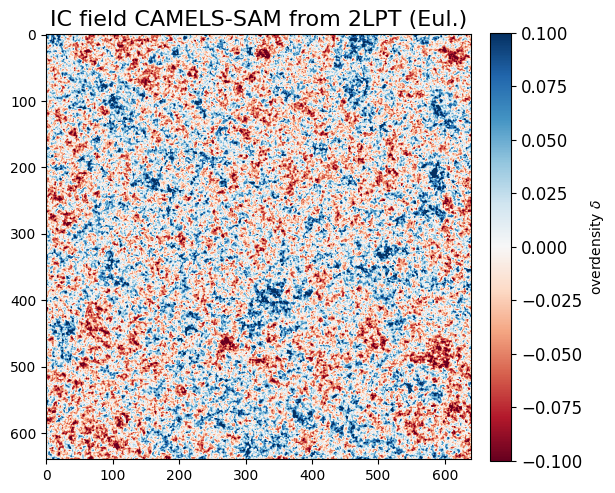

In [9]:
plotter.plot_overdensity_field(overdensity_direct, title=r'IC field CAMELS-SAM from 2LPT (Eul.)',
                               vmax=0.1
                               )

## Replicate with BACCO

In [10]:
fn_params_all = '../data/params_CAMELS-SAM.dat'
df_params = pd.read_csv(fn_params_all)
params = df_params.loc[idx_sam]
print(params)

idx_LH          16.00000
Omega_m          0.28220
sigma_8          0.81540
A_SN1_x1.7       1.79444
A_SN2_p3         1.92200
A_AGN_x0.002     0.00514
Name: 16, dtype: float64


In [11]:
a_Quijote = 1
# fixed params (https://camels-sam.readthedocs.io/en/main/simulations.html)
Ob = 0.049
hubble = 0.6711
ns = 0.9624
cosmopars = dict(
        omega_cdm=params['Omega_m']-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=params['sigma_8'],
        tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag=f"cosmo_LH{idx_sam}"
    )
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2024-05-13 23:08:15,501 bacco.cosmo :    initialization took 0.000 secs


In [12]:
a_start = 1./128.
cosmo_Quijote_z127 = bacco.Cosmology(**cosmopars)
cosmo_Quijote_z127.set_expfactor(a_start)

2024-05-13 23:08:16,174 bacco.cosmo :    initialization took 0.000 secs


In [13]:
n_threads = 8
LPT_order = 2
bacco.configuration.update({'scaling' : {'LPT_order' : LPT_order}})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})
bacco.configuration.update({'number_of_threads': n_threads})

In [14]:
# CREATE A ZA SIMULATION - as a check, do at same expfactor as CAMELS-SAM ICs
print("Generating LPT sim")
sim_z127, disp_field_z127 = bacco.utils.create_lpt_simulation(cosmo_Quijote_z127, box_size, Nmesh=ngrid, Seed=seed,
                                                    FixedInitialAmplitude=False,InitialPhase=0, 
                                                    expfactor=1./128., LPT_order=LPT_order, order_by_order=None,
                                                    phase_type=1, ngenic_phases=True, return_disp=True, 
                                                    sphere_mode=0)

2024-05-13 23:08:17,499 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-05-13 23:08:17,500 bacco.sims : Initialising simulation Default
2024-05-13 23:08:17,501 bacco.sims : ...done in 0.00106 s


Generating LPT sim


2024-05-13 23:08:18,421 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.389 secs
2024-05-13 23:08:18,422 bacco.cosmo :    created Pk(z=0) tab from k 7.450454722857103e-05 to 100000.0 h/Mpc
2024-05-13 23:08:35,355 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.236 secs
2024-05-13 23:08:35,357 bacco.cosmo :    created Pk(z=0) tab from k 7.450454722857103e-05 to 100000.0 h/Mpc


bacco.lss_scaler : 289 P(k) values; Di = (0.010173, 0.000103, 0.000001, 0.000001); nthreads =8; seed =5016 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =5016 ngrid=640 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss_scaler: Computing 2LPT density...
l2=-2.70767e-17 
l2=-1.77865e-17 
l2=-4.01154e-17 
l2=2.03263e-17 
l2=-1.99015e-17 
l2=3.06461e-17 
bacco.lss_scaler: Fourier transforming second order source...
l2=-5.54649e-08 l3a=-9.52566e-08 l3b=-1.12811e-07


2024-05-13 23:09:27,293 bacco.scaler : Adding displacement field with a vel-factor=601.012446


bacco.lss_scaler:  Adding LSS displacement: vel_factor=601.012446 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [16]:
pos_mesh_bacco_z127 = bacco.statistics.compute_mesh(ngrid=ngrid, box=box_size,
                                         pos=sim_z127.sdm['pos'], vel=sim_z127.sdm['vel'], mass=None,
                 interlacing=False, deposit_method='cic', folds=1,
                 zspace=False, cosmology=None, nthreads=None, twod=False)

2024-05-13 23:09:57,882 bacco.statistics : Computing cic mesh with ngrid=640 and interlacing=False
2024-05-13 23:09:57,883 bacco.statistics : starting deposit 1
2024-05-13 23:10:02,339 bacco.statistics :  mesh done in 4.46 s


bacco.mesh : boxsize=100.000000 ngrid=640, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 1000.0 Mb
bacco.mesh : binning of 262144000 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


In [20]:
lin_field_bacco_z127 = pos_mesh_bacco_z127[0]
overdensity_bacco_z127 = lin_field_bacco_z127/np.mean(lin_field_bacco_z127) - 1

-0.26069617 0.36816478


-0.26069617 0.36816478


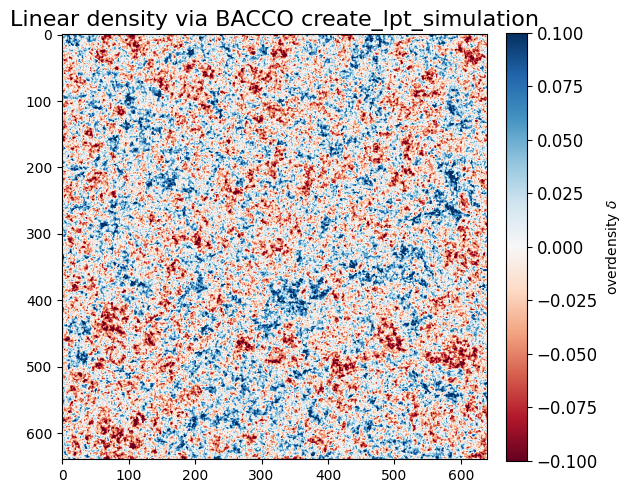

In [21]:
plotter.plot_overdensity_field(overdensity_bacco_z127, 
                               title=r'Linear density via BACCO create_lpt_simulation',
                               vmax=0.1
                               )

In [22]:
fields_sim_z127_lag = sim_z127.get_linear_field(ngrid=ngrid)

bacco.lss_scaler : 289 P(k) values; Di = (0.010173, 0.000103, 0.000001, 0.000001); nthreads =8; seed =5016 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =5016 ngrid=640 pkfixed=0 phase=0.000000, phase_type=0; precision=single 


In [23]:
# already mean-zero, so it's already overdensity
overdensity_bacco_z127_lag = fields_sim_z127_lag[0]

-0.34771018545143306 0.31914631836116314
-0.34771018545143306 0.31914631836116314


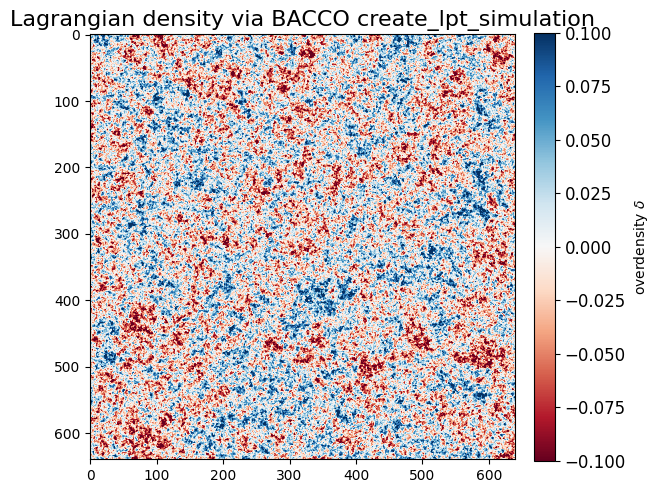

In [24]:
plotter.plot_overdensity_field(overdensity_bacco_z127_lag, title=r'Lagrangian density via BACCO create_lpt_simulation',
                               vmax=0.1)

### Check residuals

In [25]:
overdensity_direct_norm = overdensity_direct/np.std(overdensity_direct)
overdensity_bacco_z127_norm = overdensity_bacco_z127/np.std(overdensity_bacco_z127)
print(np.mean(overdensity_direct_norm), np.std(overdensity_direct_norm))
print(np.mean(overdensity_bacco_z127_norm), np.std(overdensity_bacco_z127_norm))

2.1977763e-05 0.9999973
-5.6165794e-05 0.999995


In [26]:
np.sum(overdensity_bacco_z127==0), np.sum(overdensity_direct==0)

(300, 112)

In [27]:
i_zero_bacco_z127 = (overdensity_bacco_z127 == 0)
print(np.where(i_zero_bacco_z127==True))
print(overdensity_bacco_z127[i_zero_bacco_z127])

(array([  3,   4,   6,   9,  10,  14,  14,  17,  18,  18,  27,  29,  30,
        31,  34,  35,  37,  37,  44,  45,  50,  51,  52,  53,  55,  59,
        60,  62,  67,  68,  69,  71,  77,  79,  84,  88,  90,  92,  93,
        94,  95,  97,  98,  99, 101, 102, 102, 104, 105, 105, 105, 107,
       110, 113, 114, 117, 118, 118, 122, 122, 122, 122, 125, 130, 130,
       132, 134, 135, 135, 138, 139, 142, 144, 148, 150, 161, 163, 163,
       167, 173, 174, 176, 176, 177, 180, 180, 186, 193, 193, 195, 197,
       202, 206, 209, 211, 212, 216, 216, 217, 217, 218, 221, 222, 223,
       227, 228, 230, 231, 235, 236, 236, 238, 242, 244, 259, 260, 263,
       269, 271, 272, 273, 275, 278, 279, 279, 280, 282, 282, 282, 285,
       286, 289, 292, 293, 296, 296, 297, 298, 298, 299, 300, 302, 309,
       310, 311, 311, 319, 319, 322, 323, 324, 324, 329, 331, 333, 334,
       335, 343, 343, 344, 349, 351, 351, 353, 356, 357, 357, 358, 359,
       362, 362, 363, 367, 370, 373, 374, 374, 375, 375, 376, 3

/tmp/ipykernel_363492/524605031.py:1: RuntimeWarning: divide by zero encountered in divide
  overdensity_residual = (overdensity_bacco_z127-overdensity_direct)/overdensity_direct


7565656.5
-0.19448765 467.27957


-1247605.0 962448.0
-1247605.0 962448.0
-1247605.0 962448.0


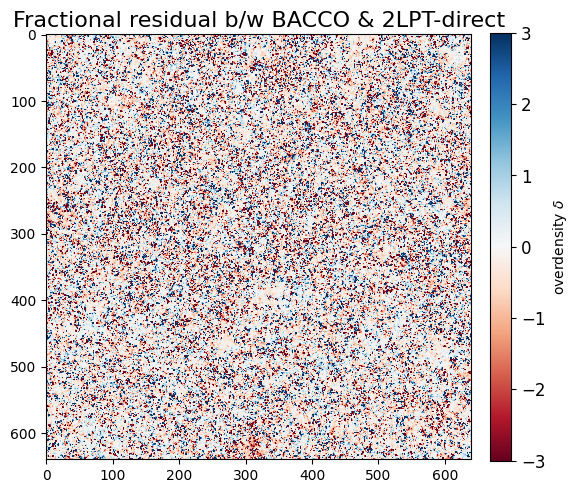

In [28]:
overdensity_residual = (overdensity_bacco_z127-overdensity_direct)/overdensity_direct

i_nonzero = (overdensity_direct != 0)
print(np.sqrt(np.sum((overdensity_residual[i_nonzero])**2)))

print(np.mean(overdensity_residual[i_nonzero]), np.std(overdensity_residual[i_nonzero]))
print(np.min(overdensity_residual[i_nonzero]), np.max(overdensity_residual[i_nonzero]))
#overdensity_residual_norm = overdensity_direct_norm - overdensity_bacco_z127_norm

overdensity_residual[~i_nonzero] = 0
plotter.plot_overdensity_field(overdensity_residual, title=r'Fractional residual b/w BACCO & 2LPT-direct',
                               vmax=3)

/tmp/ipykernel_363492/2722386309.py:1: RuntimeWarning: divide by zero encountered in divide
  overdensity_residual_norm = (overdensity_bacco_z127_norm-overdensity_direct_norm)/overdensity_direct_norm


-inf inf
-inf inf


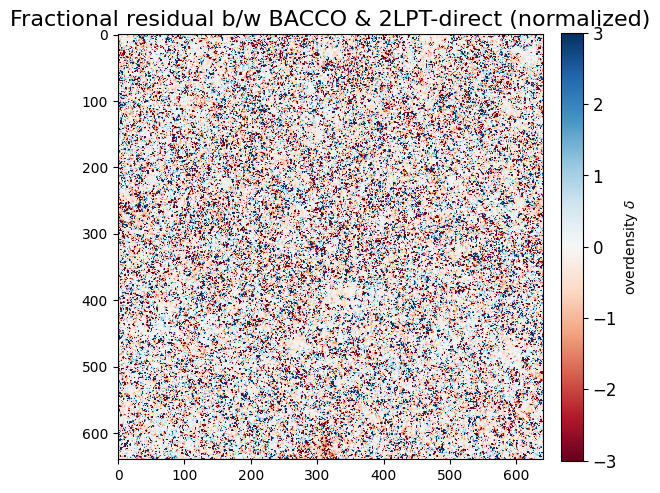

In [29]:
overdensity_residual_norm = (overdensity_bacco_z127_norm-overdensity_direct_norm)/overdensity_direct_norm

plotter.plot_overdensity_field(overdensity_residual_norm, title=r'Fractional residual b/w BACCO & 2LPT-direct (normalized)',
                               vmax=3)

-0.26330268 0.23110974
-0.26330268 0.23110974


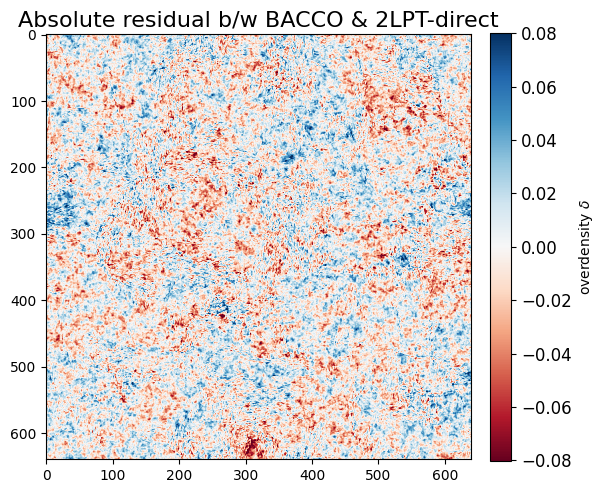

In [30]:

overdensity_residual_abs = (overdensity_bacco_z127-overdensity_direct)
plotter.plot_overdensity_field(overdensity_residual_abs, title=r'Absolute residual b/w BACCO & 2LPT-direct',
                              )

-5.6318665 4.9516797
-5.6318665 4.9516797


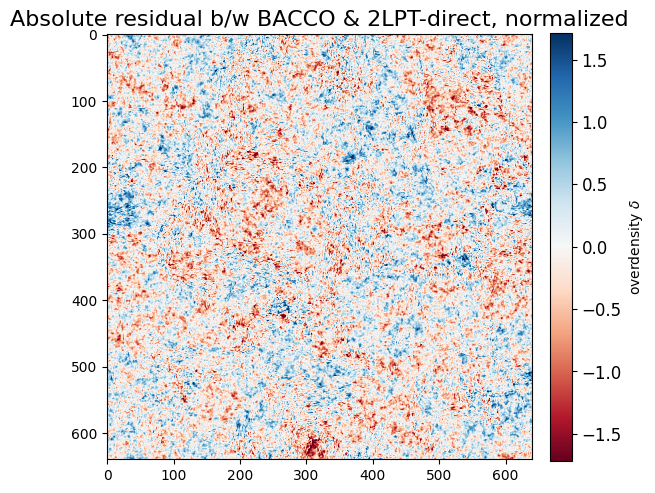

In [31]:
overdensity_residual_abs_norm = (overdensity_bacco_z127_norm-overdensity_direct_norm)

plotter.plot_overdensity_field(overdensity_residual_abs_norm, title=r'Absolute residual b/w BACCO & 2LPT-direct, normalized',
                              )

Text(0, 0.5, 'number per bin (normalized)')

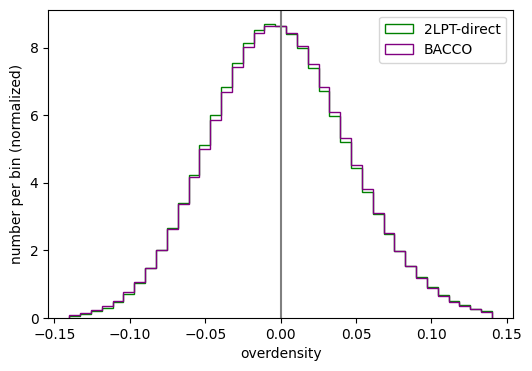

In [32]:
plt.figure(figsize=(6,4))
odens = overdensity_direct.flatten()

#stdev = 0.5*(np.percentile(odens, 84) - np.percentile(odens, 16))
stdev = np.std(odens)
mean, variance = 0, stdev**2

edge = 3*stdev
bins = np.linspace(-edge, edge, 40)
x_normal = np.linspace(-edge, edge, 1000)
y_normal = np.exp(-np.square(x_normal-mean)/2*variance)/(np.sqrt(2*np.pi*variance))
    
plt.hist(odens, bins=bins, density=True, histtype='step', color='green', label='2LPT-direct')
#plt.plot(x_normal, y_normal, label='gaussian', color='k')

odens = overdensity_bacco_z127.flatten()
plt.hist(odens, bins=bins, density=True, histtype='step', color='purple', label='BACCO')
 
plt.legend()

plt.axvline(0, color='grey')

plt.xlabel('overdensity')
plt.ylabel('number per bin (normalized)')


Text(0, 0.5, 'number per bin (normalized)')

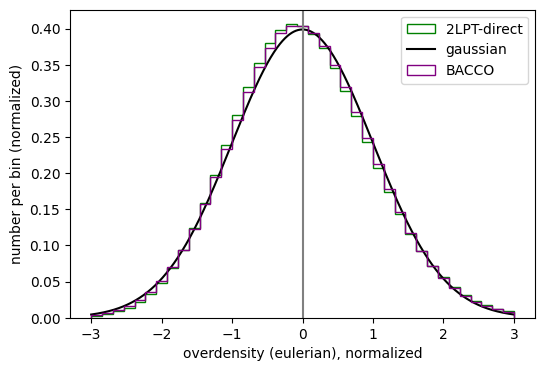

In [36]:
plt.figure(figsize=(6,4))
odens = overdensity_direct_norm.flatten()

#stdev = 0.5*(np.percentile(odens, 84) - np.percentile(odens, 16))
stdev = np.std(odens)
mean, variance = 0, stdev**2

edge = 3*stdev
bins = np.linspace(-edge, edge, 40)
x_normal = np.linspace(-edge, edge, 1000)
y_normal = np.exp(-np.square(x_normal-mean)/2*variance)/(np.sqrt(2*np.pi*variance))
    
plt.hist(odens, bins=bins, density=True, histtype='step', color='green', label='2LPT-direct')

plt.plot(x_normal, y_normal, label='gaussian', color='k')

odens = overdensity_bacco_z127_norm.flatten()
plt.hist(odens, bins=bins, density=True, histtype='step', color='purple', label='BACCO')
 
plt.legend()

plt.axvline(0, color='grey')

plt.xlabel('overdensity (eulerian), normalized')
plt.ylabel('number per bin (normalized)')


Text(0, 0.5, 'number per bin (normalized)')

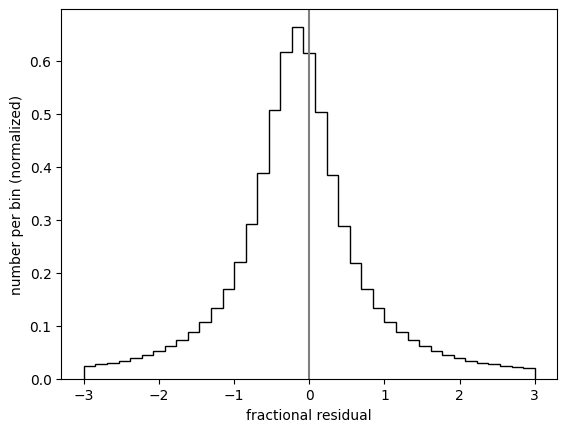

In [34]:
odens = overdensity_residual.flatten()

bins = np.linspace(-3, 3, 40)
x_normal = np.linspace(-3, 3, 1000)
stdev = 0.5*(np.percentile(odens, 84) - np.percentile(odens, 16))
mean, variance = 0, stdev**2
y_normal = np.exp(-np.square(x_normal-mean)/2*variance)/(np.sqrt(2*np.pi*variance))
    
plt.hist(odens, bins=bins, density=True, histtype='step', color='black')
#plt.plot(x_normal, y_normal, label='gaussian', color='k')
plt.axvline(0, color='grey')

plt.xlabel('fractional residual')
plt.ylabel('number per bin (normalized)')

Text(0, 0.5, 'number per bin (normalized)')

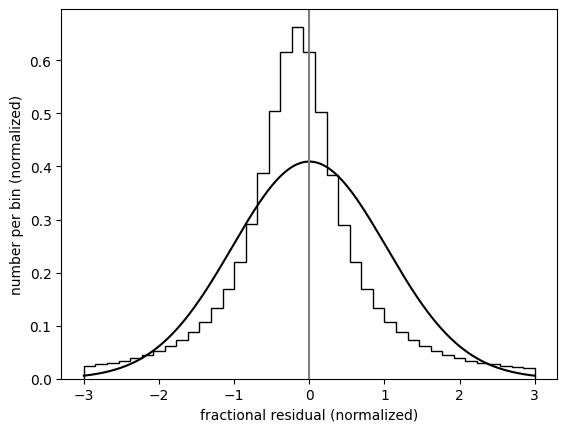

In [35]:
odens = overdensity_residual_norm.flatten()

bins = np.linspace(-3, 3, 40)
x_normal = np.linspace(-3, 3, 1000)
stdev = 0.5*(np.percentile(odens, 84) - np.percentile(odens, 16))
mean, variance = 0, stdev**2
y_normal = np.exp(-np.square(x_normal-mean)/2*variance)/(np.sqrt(2*np.pi*variance))
    
plt.hist(odens, bins=bins, density=True, histtype='step', color='black')
plt.plot(x_normal, y_normal, label='gaussian', color='k')
plt.axvline(0, color='grey')

plt.xlabel('fractional residual (normalized)')
plt.ylabel('number per bin (normalized)')


In [38]:
print("much better!")

much better!


### BACCO 2LPT at z=0

We'll actually need the sim at the redshift of the tracers, z=0, for the poob bias

In [29]:
print("Generating LPT sim")
sim, disp_field = bacco.utils.create_lpt_simulation(cosmo_Quijote, box_size, Nmesh=ngrid, Seed=seed,
                                                    FixedInitialAmplitude=False,InitialPhase=0, 
                                                    expfactor=1, LPT_order=LPT_order, order_by_order=None,
                                                    phase_type=1, ngenic_phases=True, return_disp=True, 
                                                    sphere_mode=0)

2024-05-09 00:39:40,773 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-05-09 00:39:40,775 bacco.sims : Initialising simulation Default
2024-05-09 00:39:40,776 bacco.sims : ...done in 0.0011 s


Generating LPT sim


2024-05-09 00:39:41,188 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.250 secs
2024-05-09 00:39:41,190 bacco.cosmo :    created Pk(z=0) tab from k 7.450454722857103e-05 to 100000.0 h/Mpc
2024-05-09 00:40:03,650 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.245 secs
2024-05-09 00:40:03,654 bacco.cosmo :    created Pk(z=0) tab from k 7.450454722857103e-05 to 100000.0 h/Mpc


bacco.lss_scaler : 289 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =8; seed =5016 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =5016 ngrid=640 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss_scaler: Computing 2LPT density...
l2=-2.70767e-17 
l2=-1.77865e-17 
l2=-4.01154e-17 
l2=2.03263e-17 
l2=-1.99015e-17 
l2=3.06461e-17 
bacco.lss_scaler: Fourier transforming second order source...
l2=-5.54649e-08 l3a=-9.52566e-08 l3b=-1.12811e-07


2024-05-09 00:41:00,852 bacco.scaler : Adding displacement field with a vel-factor=49.532296


bacco.lss_scaler:  Adding LSS displacement: vel_factor=49.532296 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [30]:
fields_sim = sim.get_linear_field(ngrid=ngrid)
overdensity_bacco = fields_sim[0]

2024-05-09 00:41:07,648 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.251 secs
2024-05-09 00:41:07,651 bacco.cosmo :    created Pk(z=0) tab from k 7.450454722857103e-05 to 100000.0 h/Mpc


bacco.lss_scaler : 289 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =8; seed =5016 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =5016 ngrid=640 pkfixed=0 phase=0.000000, phase_type=0; precision=single 


In [31]:

print(sim.Cosmology.get_growth_z(1/128))
print(np.std(fields_sim[0]), np.std(fields_sim_z127[0]))
print(np.std(fields_sim[0]*sim.Cosmology.get_growth_z(1/128)))
tol = 1e-8
assert np.abs(np.std(fields_sim[0]*sim.Cosmology.get_growth_z(1/128)) - np.std(fields_sim_z127[0])) < tol, "Should be equal"

0.010172587435262375
5.289897924520549 0.0538119462678582
0.05381194916079798


-34.18109938502312 31.373172998428345
-34.18109938502312 31.373172998428345


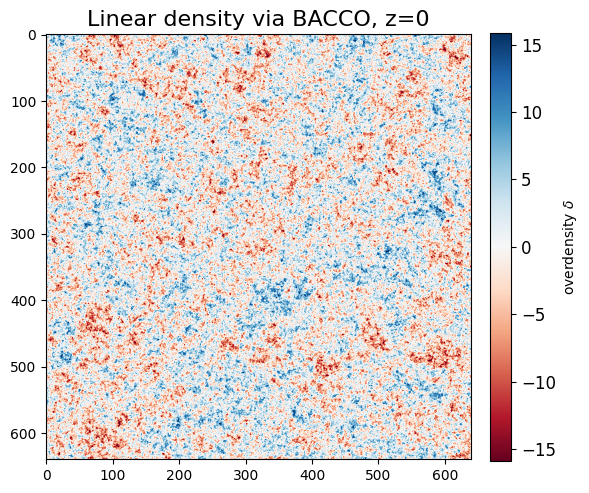

In [32]:
plotter.plot_overdensity_field(overdensity_bacco, title=r'Linear density via BACCO, z=0',
                               )

Check damped field - which will be what the prob bias calls

In [33]:
damping_scale = 0.2
fields_sim_damped = sim.get_linear_field(ngrid=ngrid, damping_scale=damping_scale)
print(fields_sim.shape)

bacco.lss_scaler : 289 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =8; seed =5016 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =5016 ngrid=640 pkfixed=0 phase=0.000000, phase_type=0; precision=single 
(5, 640, 640, 640)


-2.4071172811090946 2.1382442209869623
-2.4071172811090946 2.1382442209869623


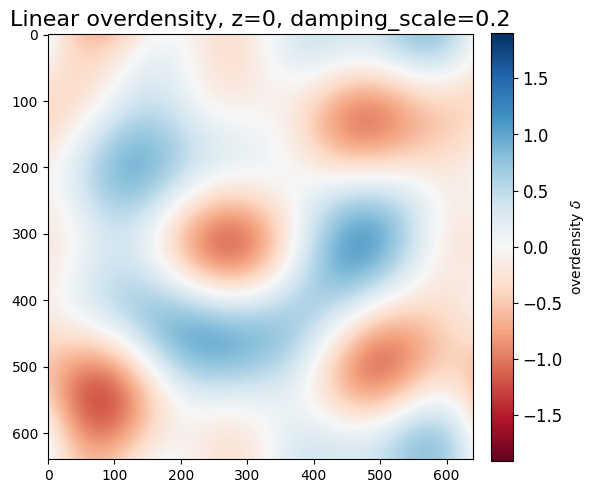

In [34]:
overdensity_bacco_damped = fields_sim_damped[0]
plotter.plot_overdensity_field(overdensity_bacco_damped, 
                          title=rf'Linear overdensity, z=0, damping_scale={damping_scale}',
                          )

In [61]:
print("hi")

hi


In [60]:
sigma_0 = np.sqrt(np.mean(overdensity_bacco_damped**2))
print(sigma_0)

0.6347896448178136


In [62]:
damping_scale = 0.1
fields_sim_damped01 = sim.get_linear_field(ngrid=ngrid, damping_scale=damping_scale)

bacco.lss_scaler : 289 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =8; seed =5016 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =5016 ngrid=640 pkfixed=0 phase=0.000000, phase_type=0; precision=single 


In [63]:
overdensity_bacco_damped01 = fields_sim_damped01[0]
sigma_0_damped01 = np.sqrt(np.mean(overdensity_bacco_damped01**2))
print(sigma_0_damped01)

0.3069435350096561


## Load CAMELS-SAM tracers

In [35]:
redshift = 0
ndens_target = 0.003 # (Mpc/h)^-3

dir_dat = '/lscratch/kstoreyf/CAMELS-SAM_data'

In [36]:
fn_dat = f"{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5"

In [37]:
# data description: https://camels-sam.readthedocs.io/en/main/dataproducts.html
# (note names don't match, not sure why - col names here: https://camels-sam.readthedocs.io/en/main/openSAM.html)
vol_hMpc = 100**3 # units Mpc/h!! 
n_target = int(ndens_target * vol_hMpc)
log_mass_shift = 9

with h5py.File(fn_dat, 'r') as f:
    print(f.keys())
    mstar_raw = np.array(f['mstar'])
    i_target = np.argsort(mstar_raw)[::-1][:n_target] # order by mstar and take largest to smallest to get desired ndens
    log_mstar = np.log10(mstar_raw) + log_mass_shift
    log_mstar = log_mstar[i_target]
    log_mhalo = np.log10(np.array(f['mhalo'])) + log_mass_shift
    log_mhalo = log_mhalo[i_target]

    # position in Mpc (comoving)
    x_arr, y_arr, z_arr = f['x_position'], f['y_position'], f['z_position']
    pos_arr = np.array([x_arr, y_arr, z_arr]).T
    pos_arr = pos_arr[i_target]

    # velocity in km/s
    vx_arr, vy_arr, vz_arr = f['vx'], f['vy'], f['vz']
    vel_arr = np.array([vx_arr, vy_arr, vz_arr]).T
    vel_arr = vel_arr[i_target]
    
    halo_id_arr = np.array(f['halo_index'], dtype=int)
    halo_id_arr = halo_id_arr[i_target]

<KeysViewHDF5 ['halo_index', 'mhalo', 'mstar', 'rhalo', 'sat_type', 'sfr', 'sfrave1gyr', 'vx', 'vy', 'vz', 'x_position', 'y_position', 'z_position']>


/tmp/ipykernel_390408/2362570942.py:11: RuntimeWarning: divide by zero encountered in log10
  log_mstar = np.log10(mstar_raw) + log_mass_shift
/tmp/ipykernel_390408/2362570942.py:13: RuntimeWarning: divide by zero encountered in log10
  log_mhalo = np.log10(np.array(f['mhalo'])) + log_mass_shift


In [38]:
log_mstar.shape, pos_arr.shape, vel_arr.shape, halo_id_arr.shape

((3000,), (3000, 3), (3000, 3), (3000,))

In [39]:
h = 0.6711
pos_arr_hMpc = pos_arr*h
np.shape(pos_arr_hMpc), np.min(pos_arr_hMpc), np.max(pos_arr_hMpc)

# don't know why negative and above 100!! for now just cut - but TODO understand
i_oob = np.any(pos_arr_hMpc<0,axis=1) | np.any(pos_arr_hMpc>box_size,axis=1)
print(i_oob.shape)
print(np.sum(i_oob))
pos_arr_hMpc = pos_arr_hMpc[~i_oob,:]
vel_arr = vel_arr[~i_oob,:]
halo_id_arr = halo_id_arr[~i_oob]
log_mstar = log_mstar[~i_oob]
log_mhalo = log_mhalo[~i_oob]

np.shape(pos_arr_hMpc), np.min(pos_arr_hMpc), np.max(pos_arr_hMpc)

(3000,)
7


((2993, 3), 0.00217000185, 99.9892023)

Text(0, 0.5, '$y$')

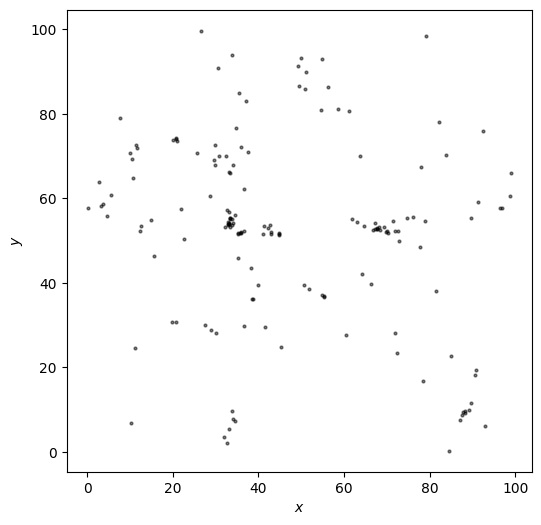

In [40]:
i_slice = (pos_arr_hMpc[:,2] < np.max(pos_arr_hMpc[:,2])/20)

plt.figure(figsize=(6, 6))
plt.scatter(pos_arr_hMpc[i_slice,0], pos_arr_hMpc[i_slice,1], color='k', s=4, alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

## Compute prob bias

In [41]:
# Define what variables we consider, "J2" means density and "J4" means Laplacian
#variables = ("J2") # only j2 needed for spatial_order=2 --- ummm it did seem to need it, TODO understand why
variables = ("J2", "J2=2")
#found that i need J2=2, else the function "deriv2_J2__2_so2" in bacco.bias_estimators fails because it uses t["J2=2"]
#variables = ("J2", "J4", "J2=2", "J2=4", "J4=4")
pbm = pb.ProbabilisticBiasManager(sim, variables=variables, damping_scale=damping_scale, ngrid=ngrid) 

In [42]:
# Define what bias parameters we want to measure
# "J2" corresponds to b1, "J22" to b2, "J24" to bdeltaL, "J4" to bL, "J44" to bL**2
# 1/2 * J2=2 = bs2
# i believe this should match emulator up to the fac of 2
#terms = ("J2", "J22", "J2=2", "J4")
terms = ("J2", "J22", "J2=2")
#terms = ("J2", "J22")

model_expansion = pbm.setup_bias_model(pb.TensorBiasND, terms=terms, spatial_order=2)

bacco.lss_scaler : 289 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =8; seed =5016 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =5016 ngrid=640 pkfixed=0 phase=0.000000, phase_type=0; precision=single 


In [43]:
from bacco.lss_scaler import lss

# adapted from bacco.simulation.create_qdata()
# https://bitbucket.org/rangulo/baccogit/src/5766697248ceb5d0554a4c78c067dd6309f008ee/bacco/simulation.py#lines-5850
def create_qdata_custom(sim, pos, vel, ids, ngrid, qdata_tolerance=0.01, 
                        number_of_threads=1, verbose=True): 

    pos = np.float32(pos)
    vel = np.float32(vel)

    vel_factor = sim.Cosmology.vel_factor(sim.Cosmology.expfactor)

    nbodies = np.size(pos[:, 0])

    _qdata = {'pos': np.zeros((nbodies, 3), dtype=np.float32),
            'vel': np.zeros((nbodies, 3), dtype=np.float32)}
    bias = np.repeat(np.float32(1.), nbodies)

    istart = 0
    nchunks = 20
    for i in range(nchunks):
        iend = istart + int(nbodies / nchunks)
        if i == (nchunks - 1):
            iend = nbodies

        # i think what was sim.header['Nsample'] is ngrid, bc 
        # https://bitbucket.org/rangulo/baccogit/src/5766697248ceb5d0554a4c78c067dd6309f008ee/bacco/utils.py?at=master#lines-1082
        _qpos, _qvel = lss.find_lagrangian_coordinates(
            pos[istart:iend, :], vel[istart:iend, :],
            ids[istart:iend], bias[istart:iend],
            qdata_tolerance, ngrid,
            sim.disp_field, sim.header['BoxSize'],
            vel_factor, number_of_threads,
            verbose)
        _qdata['pos'][istart:iend, :] = _qpos
        _qdata['vel'][istart:iend, :] = _qvel
        istart = iend
        
    return _qdata

In [44]:
id_arr_ones = np.ones_like(halo_id_arr)
qdata = create_qdata_custom(sim, pos_arr_hMpc, vel_arr, id_arr_ones, ngrid)

2024-05-09 00:48:47,873 bacco.sims : Generating displacement field: Di=1.0


bacco.lss_scaler : 289 P(k) values; Di = (1.000000, 1.000000, -0.113175, 0.121336); nthreads =8; seed =5016 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =5016 ngrid=640 pkfixed=0 phase=0.000000, phase_type=0; precision=single 
bacco.lss_scaler: Computing 2LPT density...
l2=-1.44978e-17 
l2=9.24085e-18 
l2=3.3268e-18 
l2=7.99751e-18 
l2=-9.65448e-19 
l2=-3.00524e-18 
bacco.lss_scaler: Fourier transforming second order source...
l2=-3.49127e-09 l3a=5.82716e-10 l3b=1.4228e-09
bacco.lss_scaler: Finding lagrangian positions for 149 particles on a 640 grid with 640**3 parts
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
bacco.lss_scaler: Finding lagrangian positions for 149 particles on a 640 grid with 640**3 parts
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
bacco.lss_scaler: Finding lagrangian positions for 149 particles on a 640 grid with 640**3 parts
bacco.lss_scaler:  starting algorithm
bacco.lss_sc

In [45]:
print(pos_arr_hMpc.shape, vel_arr.shape)
print(qdata['pos'].shape, qdata['vel'].shape)

(2993, 3) (2993, 3)
(2993, 3) (2993, 3)


In [46]:
# looked thru code, reproducing here to be able to do without a sim
tracer_q = qdata['pos'] #??
# dm_field_ip = pbm._create_interpolator(pbm.dm_field)
# tracer_value = dm_field_ip(tracer_q)

In [47]:
print(model_expansion.variables, model_expansion.terms)
b, bcov = pbm.fit_bias(model=model_expansion, tracer_q=tracer_q,
                       #tracer_value=tracer_value,
                       #tracer_type="fof", mask=mask, 
                       error="jack4")
#print(bcov)
print("b1 = %.2f +- %.2f" % (b[0], np.sqrt(bcov[0,0])))
print("b2 = %.2f +- %.2f" % (b[1], np.sqrt(bcov[1,1])))
print("2bs2 = %.2f +- %.2f" % (b[2], np.sqrt(bcov[2,2])))

('J2', 'J2=2') ('J2', 'J22', 'J2=2')
(2993, 3) (2993, 2)
b1 = -0.07 +- 0.14
b2 = 0.03 +- 0.30
2bs2 = -2.31 +- 0.90


### Check dependence on qdata computation

In [48]:
id_arr_zeros = np.zeros_like(halo_id_arr)
qdata_check = create_qdata_custom(sim, pos_arr_hMpc, vel_arr, id_arr_zeros, ngrid)

bacco.lss_scaler: Finding lagrangian positions for 149 particles on a 640 grid with 640**3 parts
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
bacco.lss_scaler: Finding lagrangian positions for 149 particles on a 640 grid with 640**3 parts
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
bacco.lss_scaler: Finding lagrangian positions for 149 particles on a 640 grid with 640**3 parts
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
bacco.lss_scaler: Finding lagrangian positions for 149 particles on a 640 grid with 640**3 parts
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
bacco.lss_scaler: Finding lagrangian positions for 149 particles on a 640 grid with 640**3 parts
bacco.lss_scaler:  starting algorithm
bacco.lss_scaler:  finished algorithm
bacco.lss_scaler: Finding lagrangian positions for 149 particles on a 640 grid with 640**3 parts
bacco.lss_scaler:  starting algorithm


(2993,)


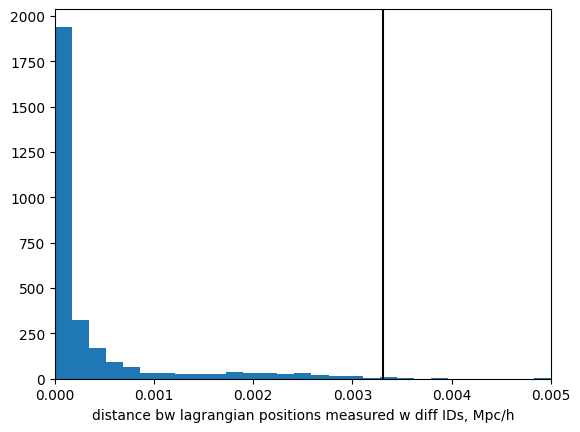

In [49]:
diffs = qdata['pos'] - qdata_check['pos']
diffs_dist = np.sqrt(np.sum(diffs**2, axis=1))
print(diffs_dist.shape)

# bc not dealing w wrapping around box edges!
i_good = diffs_dist<30
xmax = 0.005
plt.hist(diffs_dist, bins=np.linspace(0, xmax, 30))
plt.xlim(0, xmax)
plt.xlabel("distance bw lagrangian positions measured w diff IDs, Mpc/h")
plt.axvline(np.mean(diffs_dist[i_good]), color='k')
plt.axvline(np.mean(diffs_dist[i_good]) + np.std(diffs_dist[i_good]), ls='--', color='k')
plt.axvline(np.mean(diffs_dist[i_good]) - np.std(diffs_dist[i_good]), ls='--', color='k')

(2993,)


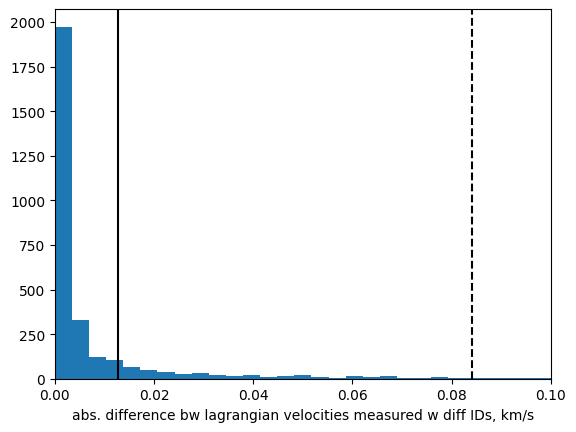

In [50]:
diffs = qdata['vel'] - qdata_check['vel']
diffs_dist = np.sqrt(np.sum(diffs**2, axis=1))
print(diffs_dist.shape)

# bc not dealing w wrapping around box edges!
i_good = diffs_dist<30
xmax = 0.1
plt.hist(diffs_dist, bins=np.linspace(0, xmax, 30))
plt.xlim(0, xmax)
plt.xlabel("abs. difference bw lagrangian velocities measured w diff IDs, km/s")
plt.axvline(np.mean(diffs_dist[i_good]), color='k')
plt.axvline(np.mean(diffs_dist[i_good]) + np.std(diffs_dist[i_good]), ls='--', color='k')
plt.axvline(np.mean(diffs_dist[i_good]) - np.std(diffs_dist[i_good]), ls='--', color='k')

Does depend on that id value :/

(2993,)


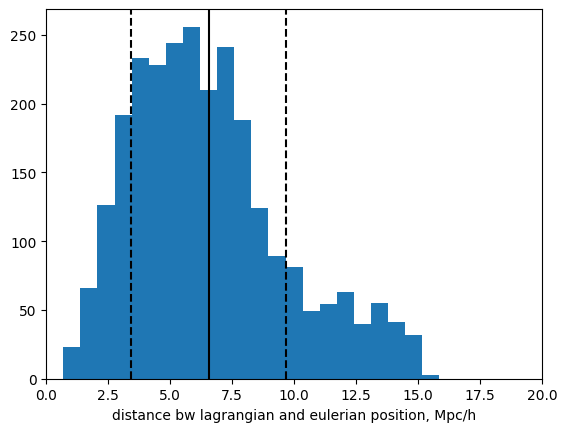

In [51]:
diffs = qdata['pos'] - pos_arr_hMpc
diffs_dist = np.sqrt(np.sum(diffs**2, axis=1))
print(diffs_dist.shape)

# bc not dealing w wrapping around box edges!
i_good = diffs_dist<30
plt.hist(diffs_dist, bins=np.linspace(0, 20, 30))
plt.xlim(0, 20)
plt.xlabel("distance bw lagrangian and eulerian position, Mpc/h")
plt.axvline(np.mean(diffs_dist[i_good]), color='k')
plt.axvline(np.mean(diffs_dist[i_good]) + np.std(diffs_dist[i_good]), ls='--', color='k')
plt.axvline(np.mean(diffs_dist[i_good]) - np.std(diffs_dist[i_good]), ls='--', color='k')

-2.956085905668783 300.56585997098216
-2166.1 1921.81


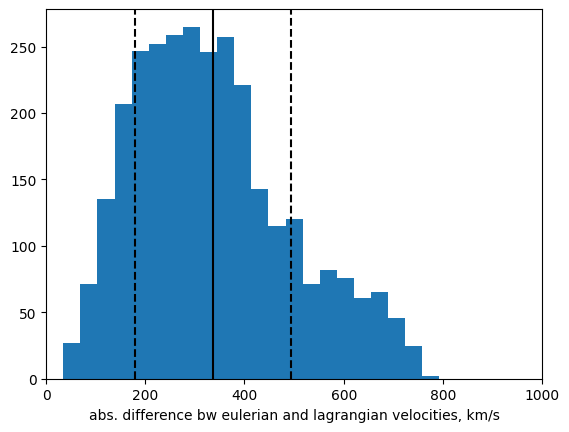

In [52]:
print(np.mean(vel_arr), np.std(vel_arr))
print(np.min(vel_arr), np.max(vel_arr))

diffs = qdata['vel'] - vel_arr
diffs_dist = np.sqrt(np.sum(diffs**2, axis=1))

# bc not dealing w wrapping around box edges!
#i_good = diffs_dist<30
i_good = np.full(diffs_dist.shape, True)
xmax = 1000.0
plt.hist(diffs_dist, bins=np.linspace(0, xmax, 30))
plt.xlim(0, xmax)
plt.xlabel("abs. difference bw eulerian and lagrangian velocities, km/s")
plt.axvline(np.mean(diffs_dist[i_good]), color='k')
plt.axvline(np.mean(diffs_dist[i_good]) + np.std(diffs_dist[i_good]), ls='--', color='k')
plt.axvline(np.mean(diffs_dist[i_good]) - np.std(diffs_dist[i_good]), ls='--', color='k')

In [53]:
# Define a set of tracers (here FoF groups selected by mass) and fit the bias. The error is estimate through a jackknife with 4**3 subboxes excluded one by one
#m200b = sim.fof['halo_m200b'] * 1e10
#mask =  ( np.log10(m200b) > 13.8 )  & ( np.log10(m200b) < 15.1 ) 
tracer_q_check = qdata_check['pos']

b, bcov = pbm.fit_bias(model=model_expansion, 
                       tracer_q=tracer_q_check,
                       #tracer_type="fof", mask=mask, 
                       error="jack4")
print("b1 = %.2f +- %.2f" % (b[0], np.sqrt(bcov[0,0])))
print("b2 = %.2f +- %.2f" % (b[1], np.sqrt(bcov[1,1])))
print("2bs2 = %.2f +- %.2f" % (b[2], np.sqrt(bcov[2,2])))

(2993, 3) (2993, 2)
b1 = -0.07 +- 0.14
b2 = 0.03 +- 0.30
2bs2 = -2.31 +- 0.90


In [54]:
# Define a set of tracers (here FoF groups selected by mass) and fit the bias. The error is estimate through a jackknife with 4**3 subboxes excluded one by one
#m200b = sim.fof['halo_m200b'] * 1e10
#mask =  ( np.log10(m200b) > 13.8 )  & ( np.log10(m200b) < 15.1 ) 
tracer_q_eul = pos_arr_hMpc

b, bcov = pbm.fit_bias(model=model_expansion, 
                       tracer_q=tracer_q_eul,
                       #tracer_type="fof", mask=mask, 
                       error="jack4")
print("b1 = %.2f +- %.2f" % (b[0], np.sqrt(bcov[0,0])))
print("b2 = %.2f +- %.2f" % (b[1], np.sqrt(bcov[1,1])))
print("2bs2 = %.2f +- %.2f" % (b[2], np.sqrt(bcov[2,2])))

(2993, 3) (2993, 2)
b1 = 1.05 +- 0.18
b2 = 1.10 +- 0.58
2bs2 = -0.22 +- 1.12


Object by object bias for fiducial: 

In [55]:
# Define a set of tracers (here FoF groups selected by mass) and fit the bias. The error is estimate through a jackknife with 4**3 subboxes excluded one by one
#m200b = sim.fof['halo_m200b'] * 1e10
#mask =  ( np.log10(m200b) > 13.8 )  & ( np.log10(m200b) < 15.1 ) 
b, bcov = pbm.fit_bias(model=model_expansion, 
                       tracer_q=tracer_q,
                       #tracer_type="fof", mask=mask, 
                       error="jack4")
print("b1 = %.2f +- %.2f" % (b[0], np.sqrt(bcov[0,0])))
print("b2 = %.2f +- %.2f" % (b[1], np.sqrt(bcov[1,1])))
print("2bs2 = %.2f +- %.2f" % (b[2], np.sqrt(bcov[2,2])))

(2993, 3) (2993, 2)
b1 = -0.07 +- 0.14
b2 = 0.03 +- 0.30
2bs2 = -2.31 +- 0.90


In [56]:
bias_per_object = pbm.bias_model.bias_per_object(pbm.tr_value)

/tmp/ipykernel_390408/2704014597.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  b1_binned = np.array([b1[(log_mstar > log_mstar_bins[i]) & (log_mstar < log_mstar_bins[i+1])] for i in range(len(log_mstar_bins)-1)])


Text(0, 0.5, '$b_1$')

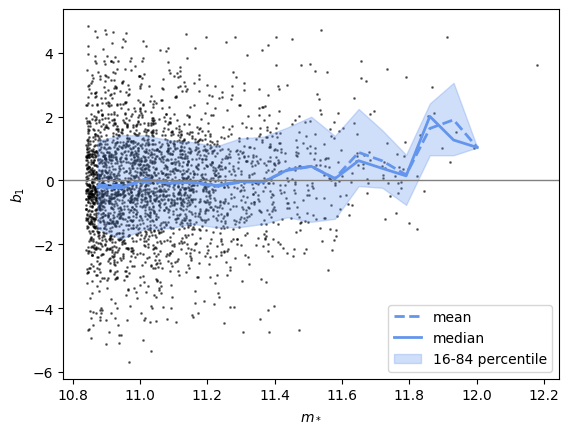

In [57]:
log_mstar_bins = np.linspace(np.min(log_mstar), np.max(log_mstar), 20)
log_mstar_bins_avg = 0.5*(log_mstar_bins[1:] + log_mstar_bins[:-1])

b1 = bias_per_object[:,0]
b1_binned = np.array([b1[(log_mstar > log_mstar_bins[i]) & (log_mstar < log_mstar_bins[i+1])] for i in range(len(log_mstar_bins)-1)])
i_hasdata = np.array([len(b1_bin) > 0 for b1_bin in b1_binned])
b1_binned = b1_binned[i_hasdata]
log_mstar_bins_avg = log_mstar_bins_avg[i_hasdata]

b1_mean = [np.mean(b1_bin) for b1_bin in b1_binned]
b1_median = [np.median(b1_bin) for b1_bin in b1_binned]
b1_16 = [np.percentile(b1_bin, 16) for b1_bin in b1_binned]
b1_84 = [np.percentile(b1_bin, 84) for b1_bin in b1_binned]

plt.scatter(log_mstar, b1, s=1, alpha=0.5, color='k')
plt.plot(log_mstar_bins_avg, b1_mean, color='cornflowerblue', lw=2, ls='--', label='mean')
plt.plot(log_mstar_bins_avg, b1_median, color='cornflowerblue', lw=2, label='median')

plt.fill_between(log_mstar_bins_avg, b1_16, b1_84, color='cornflowerblue', alpha=0.3, label='16-84 percentile')

plt.axhline(0, color='grey', lw=1)
plt.legend()
plt.xlabel(r'$m_*$')
plt.ylabel(r'$b_1$')

/tmp/ipykernel_390408/1213318499.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  b1_binned = np.array([b1[(log_mhalo > log_mhalo_bins[i]) & (log_mhalo < log_mhalo_bins[i+1])] for i in range(len(log_mhalo_bins)-1)])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$b_2$')

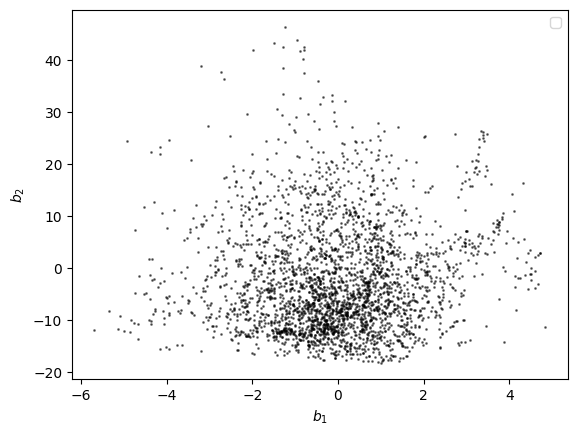

In [58]:
log_mhalo_bins = np.linspace(np.min(log_mhalo), np.max(log_mhalo), 20)
log_mhalo_bins_avg = 0.5*(log_mhalo_bins[1:] + log_mhalo_bins[:-1])

b1 = bias_per_object[:,0]
b2 = bias_per_object[:,2]

b1_binned = np.array([b1[(log_mhalo > log_mhalo_bins[i]) & (log_mhalo < log_mhalo_bins[i+1])] for i in range(len(log_mhalo_bins)-1)])
i_hasdata = np.array([len(b1_bin) > 0 for b1_bin in b1_binned])
b1_binned = b1_binned[i_hasdata]
log_mhalo_bins_avg = log_mhalo_bins_avg[i_hasdata]

b1_mean = [np.mean(b1_bin) for b1_bin in b1_binned]
b1_median = [np.median(b1_bin) for b1_bin in b1_binned]
b1_16 = [np.percentile(b1_bin, 16) for b1_bin in b1_binned]
b1_84 = [np.percentile(b1_bin, 84) for b1_bin in b1_binned]

plt.scatter(b1, b2, s=1, alpha=0.5, color='k')
#plt.plot(log_mhalo_bins_avg, b1_mean, color='cornflowerblue', lw=2, ls='--', label='mean')
#plt.plot(log_mhalo_bins_avg, b1_median, color='cornflowerblue', lw=2, label='median')

#plt.fill_between(log_mhalo_bins_avg, b1_16, b1_84, color='cornflowerblue', alpha=0.3, label='16-84 percentile')

#plt.axhline(0, color='grey', lw=1)
plt.legend()
plt.xlabel(r'$b_1$')
plt.ylabel(r'$b_2$')

In [206]:
log_mhalo_fine = np.linspace(np.min(log_mhalo), np.max(log_mhalo), 200)
mhalo_fine = 10**log_mhalo_fine

b1_mhalo_theory_eul = cosmo_Quijote.compute_biasfunction(mass=mhalo_fine,
                        expfactor=1.0)
b1_mhalo_theory = b1_mhalo_theory_eul - 1

2024-05-09 11:07:46,731 bacco.cosmo :    computed bias function relation at z=0.00 in 0.000 secs


/tmp/ipykernel_289104/1006309708.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  b1_binned = np.array([b1[(log_mhalo > log_mhalo_bins[i]) & (log_mhalo < log_mhalo_bins[i+1])] for i in range(len(log_mhalo_bins)-1)])


Text(0, 0.5, '$b_1$')

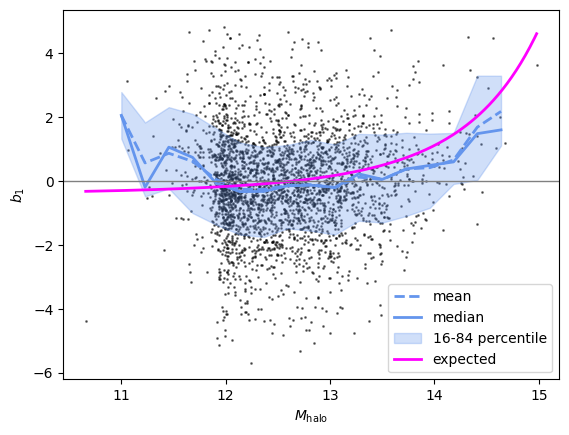

In [208]:
log_mhalo_bins = np.linspace(np.min(log_mhalo), np.max(log_mhalo), 20)
log_mhalo_bins_avg = 0.5*(log_mhalo_bins[1:] + log_mhalo_bins[:-1])

b1 = bias_per_object[:,0]
b1_binned = np.array([b1[(log_mhalo > log_mhalo_bins[i]) & (log_mhalo < log_mhalo_bins[i+1])] for i in range(len(log_mhalo_bins)-1)])
i_hasdata = np.array([len(b1_bin) > 0 for b1_bin in b1_binned])
b1_binned = b1_binned[i_hasdata]
log_mhalo_bins_avg = log_mhalo_bins_avg[i_hasdata]

b1_mean = [np.mean(b1_bin) for b1_bin in b1_binned]
b1_median = [np.median(b1_bin) for b1_bin in b1_binned]
b1_16 = [np.percentile(b1_bin, 16) for b1_bin in b1_binned]
b1_84 = [np.percentile(b1_bin, 84) for b1_bin in b1_binned]

plt.scatter(log_mhalo, b1, s=1, alpha=0.5, color='k')
plt.plot(log_mhalo_bins_avg, b1_mean, color='cornflowerblue', lw=2, ls='--', label='mean')
plt.plot(log_mhalo_bins_avg, b1_median, color='cornflowerblue', lw=2, label='median')

plt.fill_between(log_mhalo_bins_avg, b1_16, b1_84, color='cornflowerblue', alpha=0.3, label='16-84 percentile')

plt.plot(log_mhalo_fine, b1_mhalo_theory, color='magenta', lw=2, label='expected')

plt.axhline(0, color='grey', lw=1)
plt.legend()
plt.xlabel(r'$M_\mathrm{halo}$')
plt.ylabel(r'$b_1$')